# Part I. Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from scipy import stats
import time

/Users/zehuacheng/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Read in data
SamSig_AC = pd.read_csv('Data/SampleSignal_AC.csv')
SamSig_IE = pd.read_csv('Data/SampleSignal_IE.csv')
Sec_Name = pd.read_csv('Data/sector_name.csv')
Sec_Trd = pd.read_csv('Data/TrdData_CISector.csv')

In [3]:
def pct_ranking(date_str, factor_df, num_grps_int = 5, delay_int = 1):
    
    '''
    Works to divide the cross-sectional data into groups of differnet factor scores;
    Outputs a dataframe;
    date_str is the portfolio re-adjustment date per cycle of type str;
    factor_df should be a dataframe of n industries of size n with trading dates behaving like index;
    num_grps_int are the desired number of ranking groups of type int;
    delay is the number of days the factor index can be retrived
    '''
    pool = factor_df.loc[factor_df['TrdDt'] == factor_df['TrdDt'][factor_df['TrdDt'].index[factor_df['TrdDt'] == 
                                                                                           date_str][0]-delay_int]] 
    # assuming knowing the factor 1 trading day later
    
    cols = [i for i in pool.columns if i not in ['TrdDt']]
    pool = pool[cols]
    grp = pd.qcut(pool.iloc[0,:],num_grps_int, 
        labels = [f'Group{i}' for i in range(num_grps_int,0,-1)]
    )
    
    assignment = pd.DataFrame({
        'Score':pool.iloc[0,:].to_list(),
        'Group':grp
    })
    
    
    return assignment

In [4]:
def TrdDates(trd_df):
    '''
    Returns a list of trading dates given any trading dataframe
    trd_df is any trading data of type dataframe
    '''
    
    TrdDt = trd_df['TrdDt'].unique()
    TrdDt = [dt.datetime.strptime(i, '%Y-%m-%d').date() for i in TrdDt]
    
    return TrdDt

In [5]:
def convert_dt(date_freq_str,types = 'date'):
    '''
    Basic converting function utilizing datetime to make the final back-testing function more efficient
    '''
    if types == 'date':
        date = dt.datetime.strptime(date_freq_str, '%Y-%m-%d').date()
        return date
    elif types == 'delta':
        time_delt = dt.timedelta(date_freq_str)
        return time_delt
    else:
        print('Error')
    

In [6]:
def rebalance_dates(TrdDt, start_dt, end_dt, freq_dt): # Natural Day Based Algo
    '''
    Works to find the schedule of rebalancing dates given back-testing range and frequency;
    outputs a list;
    TrdDt is the trading dates;
    start is the starting day of the back-testing of str format;
    end is the ending day of the back-testing of str format;
    freq is the frequency of the back-testing of str format in the unit of day;
    '''
    dates = [start_dt]
    list_1 = [0]+[1]*364
    for i in range(1,int((end_dt-start_dt)/freq_dt)+1): 
        date = dates[i-1]+freq_dt
        if date > end_dt:
            break
        for j in list_1: # if the readjustment date isn't trading day, shift to the next day
            date += dt.timedelta(list_1[j]) # shifting range is limited to 365d
            if date in TrdDt:
                if date > end_dt:
                    break
                dates.append(date)
                break
    
    return dates

In [7]:
def rebalance_dates_v2(TrdDt, start_dt, end_dt, freq_str, assign = False): # Trading Day Based Algo
    '''
    Works to find the schedule of rebalancing dates given back-testing range and frequency;
    outputs a list;
    TrdDt is the trading dates;
    start is the starting day of the back-testing of str format;
    end is the ending day of the back-testing of str format;
    freq is the frequency of the back-testing of str format in the unit of day;
    '''
    if not assign:
        dates = []
        rebalance_list = np.arange(TrdDt.index(start_dt),TrdDt.index(end_dt), int(freq_str))
        for i in rebalance_list:
            dates.append(TrdDt[i])
    
    else: 
        dates = assign
    
    return dates

In [8]:
def buy_sell_single(factor_df, TrdDt, start_dt, end_dt, freq_str, assign = False, num_grps_int=5, delay_int=1):
    '''
    The version without rolling windows. Figured would have too many for-loops if included.
    Will include the windows afterwards.
    '''
    dates_df = rebalance_dates_v2(TrdDt, start_dt, end_dt, freq_str, assign)
    schedule = pd.DataFrame()
    for i in dates_df:
        test_df = pct_ranking(str(i), factor_df, num_grps_int, delay_int)
        schedule = pd.concat([schedule, test_df.groupby('Group').apply(lambda x: x.index.tolist())], axis=1)
    
    column_names = [date.strftime('%Y-%m-%d') for date in dates_df]
    schedule.columns = column_names
    
    return schedule

In [9]:
def sec_id(sec_name_str, sec_name_df):
    '''
    Given sector name outputs its corresponding sector id.
    For now, assume sector ID column is always named 'SecCd'
    '''
    sec_id = sec_name_df.loc[sec_name_df['SecName'] == sec_name_str, 'SecCd'].iloc[0]
    return sec_id

In [10]:
def sec_name(sec_id_str, sec_name_df):
    '''
    Given sector ID outputs its corresponding sector name.
    For now, assume sector name column is always named 'SecName'
    '''
    sec_name = sec_name_df.loc[sec_name_df['SecCd'] == sec_id_str, 'SecName'].iloc[0]
    return sec_name

In [11]:
def days_diff(dates_list,start_dt,end_dt):
   
    left = dates_list.index(start_dt)
    right = dates_list.index(end_dt)
    
    return right - left

In [12]:
def date_diff(dates_list, start_dt, end_dt):
    left = dates_list.index(start_dt)
    right = dates_list.index(end_dt)
    
    daytime = []
    for i in dates_list[left+1:right]:
        daytime.append(i.strftime('%Y-%m-%d'))
    return daytime

In [13]:
def max_drawdown(array):
    drawdowns = []
    max_so_far = array.iloc[1]
    for i in range(len(array)-1):
        if array.iloc[i+1] > max_so_far:
            drawdown = 0
            drawdowns.append(drawdown)
            max_so_far = array.iloc[i+1]
        else:
            drawdown = max_so_far - array.iloc[i+1]
            drawdowns.append(drawdown)
    return max(drawdowns)

In [14]:
def roll_rebalance_dates(TrdDt, start_dt, end_dt, freq_str,assign = False, roll_window_int = 0):
    '''
    Adds another layer to the original rebalance_dates function, 
    allowing for sensitivity tests of the factor as well as the strategies' timeliness;
    roll_window_int is the integer of the desired rolling window of the rebalancing dates
    '''
    
    forward_dict = {} 
    backward_dict = {}
    if not assign:
        for i in range(roll_window_int + 1):
            if i == 0:
                Origin = rebalance_dates_v2(TrdDt, start_dt, end_dt, freq_str)
                continue
            forward_dict[f'{i}-Day After'] = rebalance_dates_v2(TrdDt, TrdDt[TrdDt.index(start_dt)+i], 
                                                                  TrdDt[TrdDt.index(end_dt)+i], freq_str)
        for i in range(roll_window_int,0,-1):
            backward_dict[f'{i}-Day Priv'] = rebalance_dates_v2(TrdDt, TrdDt[TrdDt.index(start_dt)-i], 
                                                                    TrdDt[TrdDt.index(end_dt)-i], freq_str)
        data_dict = {**backward_dict, 'Origin': Origin, **forward_dict}
        df = pd.DataFrame(data_dict)
    
    else:
        for i in range(roll_window_int + 1):
            assign_shift = []
            if i == 0:
                Origin = rebalance_dates_v2(TrdDt, start_dt, end_dt, freq_str, assign)
                continue
            for j in range(len(assign)):
                assign_shift.append(TrdDt[TrdDt.index(assign[j])+i])
            forward_dict[f'{i}-Day After'] = assign_shift
            
        data_dict = {'Origin': Origin, **forward_dict}
        df = pd.DataFrame(data_dict)
        return df
    
    return df.iloc[0,:],df.iloc[-1,:]

In [15]:
def frame_df(factor_df, sec_name_df, trd_dt, TrdDt, start_dt, end_dt, freq_str = 5, assign = False, 
             num_grps_int=5, delay_int = 1):
        
    schedule = buy_sell_single(factor_df, TrdDt, start_dt, end_dt, freq_str,assign, num_grps_int, delay_int)

    # Create empty lists
    Sec_id = []
    Date = []
    Group = []

    # reb_dates = rebalance_dates_v2(TrdDt, start_dt, end_dt, freq_str)

    # Iterate over schedule columns and rows
    for i in range(len(schedule.columns)):
        for j in range(len(schedule.index)):
            for k in schedule.iloc[j, i]:
                Sec_id.append(sec_id(k, sec_name_df))
                Date.append(schedule.columns[i])
                Group.append(schedule.index[j])
        if i != (len(schedule.columns) - 1):
            # Extend lists using list repetition
            Sec_id.extend(Sec_id[-len(factor_df.columns) + 1:] * (days_diff(TrdDt, convert_dt(schedule.columns[i]),
                                                                           convert_dt(schedule.columns[i + 1])) - 1))
            Date.extend([num for num in date_diff(TrdDt, convert_dt(schedule.columns[i]),
                                                  convert_dt(schedule.columns[i + 1]))
                         for _ in range(len(factor_df.columns) - 1)])
            Group.extend(Group[-len(factor_df.columns) + 1:] * (days_diff(TrdDt, convert_dt(schedule.columns[i]),
                                                                         convert_dt(schedule.columns[i + 1])) - 1))
    Sec_id.extend(Sec_id[-len(factor_df.columns) + 1:] * (days_diff(TrdDt, convert_dt(schedule.columns[-1]), end_dt)))
    Date.extend([num for num in date_diff(TrdDt, convert_dt(schedule.columns[-1]), TrdDt[TrdDt.index(end_dt) + 1])
                  for _ in range(len(factor_df.columns) - 1)])
    Group.extend(Group[-len(factor_df.columns) + 1:] * (days_diff(TrdDt, convert_dt(schedule.columns[-1]), end_dt)))

    # Create a DataFrame using a dictionary
    frame_dict = {'Sec_id': Sec_id, 'Date': Date, 'Group': Group}
    frame = pd.DataFrame(frame_dict)

    # Use merge instead of multiple calls to loc for better performance
    frame = frame.merge(trd_dt[['IdxCd', 'TrdDt', 'ClsIdx']], how='left', left_on=['Sec_id', 'Date'], right_on=['IdxCd', 'TrdDt'])
    frame['SectorValue'] = None  # Create an empty column for sector values
    for i, row in frame.iterrows():
        date = row['Date']
        sector_id = row['Sec_id']
        sector_name = sec_name(sector_id, sec_name_df)  # Use the sec_name() function to get the sector name
     # Retrieve the corresponding sector value from factor_df DataFrame
        sector_value = factor_df.loc[factor_df['TrdDt'] == date, sector_name].values[0]

            # Assign the sector value to the 'SectorValue' column in frame DataFrame
        frame.at[i, 'SectorValue'] = sector_value
    
    return frame

In [16]:
def back_test_v2(factor_df, sec_name_df, trd_dt, start_dt, end_dt, assign = False, rate = 0.002, freq_str = 5, 
                 num_grps_int=5, delay_int = 1, show_plots = True, show_table = True):
    
    TrdDt = TrdDates(factor_df)
    
    frame = frame_df(factor_df, sec_name_df, trd_dt, TrdDt, start_dt, end_dt, freq_str, assign, 
                     num_grps_int, delay_int)
    
    frame['TrdDt'] = pd.to_datetime(frame['TrdDt'])

    # Calculate individual sector returns
    frame['Return'] = frame.groupby('Sec_id')['ClsIdx'].pct_change()

    # Calculate cumulative returns per group
    grouped_df = frame.groupby(['Group','TrdDt'])['Return'].mean()
    df = grouped_df.reset_index()
    df['CumulativeReturn'] = df.groupby('Group')['Return'].cumsum()

    # Calculate relative cumulative percent change per group
    df2 = (df.groupby(['Group','TrdDt'])['Return'].mean() - grouped_df.groupby('TrdDt').mean()).reset_index()

    # Calculate the cumulative sum per group
    df2['CumulativeSum'] = df2.groupby('Group')['Return'].cumsum()
    max_group = len(frame['Group'].unique())
    sec_max_group = len(frame['Group'].unique()) - 1
    # Calculate the long/short relative return of Group 1-5
    group1_5_return = df2[df2['Group'] == 'Group1']['CumulativeSum'].values - df2[df2['Group'] == f'Group{max_group}']['CumulativeSum'].values

    # Calculate the long/short relative return of Group 2-4
    group2_4_return = df2[df2['Group'] == 'Group2']['CumulativeSum'].values - df2[df2['Group'] == f'Group{sec_max_group}']['CumulativeSum'].values
    reb_dates = rebalance_dates_v2(TrdDt, start_dt, end_dt, freq_str, assign)
    corr_series = []
    group1_sharpe_ratio = []
    group1_ExRet = []
    group1_Cal = []
    group1_5_ExRet = []
    group1_5_sharpe_ratio = []
    group1_5_Cal = []
    positive_count_ratio = []
    negative_count_ratio = []
    group1_diff_rate = []
    group5_diff_rate = []
    
    group1_max_drawdown = max_drawdown(df2[df2['Group'] == 'Group1']['CumulativeSum'])
    group1_5_max_drawdown = max_drawdown(pd.Series(group1_5_return))
    
    
    for j in range(len(reb_dates)-2):
        g1_diff_list = []
        g5_diff_list = []
        
        schedule_sectors = buy_sell_single(factor_df, TrdDt, reb_dates[j], reb_dates[j+2], freq_str, assign,
                                           num_grps_int, delay_int)
        compo_g1 = schedule_sectors.loc['Group1']
        compo_g5 = schedule_sectors.loc['Group5']
        for k in range(1, len(compo_g1)):
            g1_compo_prev = set(compo_g1[k-1])
            g1_compo_curr = set(compo_g1[k])
            g1_diff_rate_curr = len(g1_compo_curr - g1_compo_prev)/len(g1_compo_prev)
            g1_diff_rate_prev = len(g1_compo_prev - g1_compo_curr)/len(g1_compo_prev)
            g1_diff_list.append(g1_diff_rate_curr+g1_diff_rate_prev)
            
            g5_compo_prev = set(compo_g5[k-1])
            g5_compo_curr = set(compo_g5[k])
            g5_diff_rate_curr = len(g5_compo_curr - g5_compo_prev)/len(g5_compo_prev)
            g5_diff_rate_prev = len(g5_compo_prev - g5_compo_curr)/len(g5_compo_prev)
            g5_diff_list.append(g5_diff_rate_curr+g5_diff_rate_prev)
        
        group1_diff_rate.append(np.mean(g1_diff_list))
        group5_diff_rate.append(np.mean(g5_diff_list))
        
        # both sides' change rates BOTH with respect to the previous cycle
    
    for i in range(len(reb_dates)-1):
        
        Return_rank = []
        SectorValue_rank = []
        testdf2 = frame[frame['Date']==str(reb_dates[i])]
        SectorValue_rank = testdf2[['IdxCd','SectorValue']].sort_values('IdxCd').reset_index().iloc[:,-1].rank(ascending=False)
        subset = frame[(frame['Date'] > str(reb_dates[i])) & (frame['Date'] <= str(reb_dates[i+1]))]
        testdf = subset.groupby(['IdxCd', 'TrdDt'])['Return'].mean().reset_index()
        testdf['CumulativeReturn'] = testdf.groupby('IdxCd')['Return'].cumsum()
        Return_rank = testdf.pivot(columns='IdxCd', index='TrdDt', values='CumulativeReturn').iloc[-1, :].rank(ascending=False)
        correlation = stats.spearmanr(Return_rank, SectorValue_rank)[0]
        corr_series.append(correlation)

        # Calculate annualized Excess Return of Group 1
        subset2 = df2[(df2['TrdDt'] > str(reb_dates[i])) & (df2['TrdDt'] <= str(reb_dates[i+1]))]
        group1_excess_return = (subset2[subset2['Group'] == 'Group1']['Return'].cumsum().iloc[-1]) * (252 / len(subset2[subset2['Group'] == 'Group1']['Return']))
        group1_ExRet.append(group1_excess_return)

        # Calculate annualized Sharpe ratio of Group 1
        group1_std = np.std(subset2[subset2['Group'] == 'Group1']['Return']) * np.sqrt(252)
        group1_sharpe_ratio.append(group1_excess_return / group1_std)

        # Calculate Calmar ratio of Group 1
        group1_calmar_ratio = group1_excess_return / abs(group1_max_drawdown)
        group1_Cal.append(group1_calmar_ratio)

        # Calculate annulized Excess Return of Long/Short (Group 1 - Group 5)
        sub_group1_5_return = subset2[subset2['Group'] == 'Group1']['Return'].values - subset2[subset2['Group'] == f'Group{max_group}']['Return'].values
        group1_5_excess_return = sub_group1_5_return.cumsum()[-1] * (252 / len(subset2[subset2['Group'] == 'Group1']['Return']))
        group1_5_ExRet.append(group1_5_excess_return)

        # Calculate annualized Sharpe ratio of Long/Short (Group 1 - Group 5)
        g1_ret = subset2[subset2['Group'] == 'Group1']['Return']
        g5_ret = subset2[subset2['Group'] == 'Group5']['Return']
        group1_5_std = np.sqrt(np.var(g1_ret) + np.var(g5_ret)) * np.sqrt(252)
        group1_5_sharpe_ratio.append(group1_5_excess_return / group1_5_std)

        # Calculate Calmar ratio of Long/Short (Group 1 - Group 5)
        group1_5_calmar_ratio = group1_5_excess_return / abs(group1_max_drawdown)
        group1_5_Cal.append(group1_5_calmar_ratio)

        # Calculate Group1 Prediction Accuracy & Group5 Prediction Accuracy
        positive_count_group1 = 0
        total_count_group1 = 0
        group1_subset = subset2[subset2['Group'] == 'Group1'].copy()

        # Calculate the relative cumulative return
        group1_subset.loc[:, 'RelativeReturn'] = group1_subset.groupby('TrdDt')['Return'].cumsum()

        # Count the positive relative cumulative return sectors for Group 1
        positive_count_group1 = len(group1_subset[group1_subset['RelativeReturn'] > 0])
        total_count_group1 = len(group1_subset)

        # Calculate the positive count ratio for Group 1
        positive_count_ratio.append(positive_count_group1 / total_count_group1)

        # Negative count and total count for Group 5
        negative_count_group5 = 0
        total_count_group5 = 0
        group5_subset = subset2[subset2['Group'] == 'Group5'].copy()

        # Calculate the relative cumulative return
        group5_subset.loc[:, 'RelativeReturn'] = group5_subset.groupby('TrdDt')['Return'].cumsum()

        # Count the negative relative cumulative return sectors for Group 5
        negative_count_group5 = len(group5_subset[group5_subset['RelativeReturn'] < 0])
        total_count_group5 = len(group5_subset)

        # Calculate the negative count ratio for Group 5
        negative_count_ratio.append(negative_count_group5 / total_count_group5)
    
#     Return_rank = []
#     SectorValue_rank = []
#     testdf2 = frame[frame['Date']==str(reb_dates[-1])]
#     SectorValue_rank = testdf2[['IdxCd','SectorValue']].sort_values('IdxCd').reset_index().iloc[:,-1].rank(ascending=False)
#     subset = frame[(frame['Date'] > str(reb_dates[-1])) & (frame['Date'] <=str(end_dt))]
#     testdf = subset.groupby(['IdxCd', 'TrdDt'])['Return'].mean().reset_index()
#     testdf['CumulativeReturn'] = testdf.groupby('IdxCd')['Return'].cumsum()
#     Return_rank = testdf.pivot(columns='IdxCd', index='TrdDt',values='CumulativeReturn').iloc[-1, :].rank(ascending=False)
#     correlation = stats.spearmanr(Return_rank, SectorValue_rank)[0]
#     corr_series.append(correlation)

    # Convert corr_series to a pandas Series
    corr_series = pd.Series(corr_series)

    # Calculate the moving average using rolling
    window_size = 8  # Set the window size for the moving average
    moving_average = corr_series.rolling(window=window_size).mean()
    if show_plots:
        # Set up subplots
        fig, axs = plt.subplots(2, 2, figsize=(18, 8))

        # Plot absolute cumulative percent change per group
        axs[0, 0].set_title('Absolute Nav')
        groups = df['Group'].unique()
        for group in groups:
            group_df = df[df['Group'] == group]
            axs[0, 0].plot(group_df['TrdDt'], group_df['CumulativeReturn'], label=f'{group}')
        axs[0, 0].set_xlabel('Date')
        axs[0, 0].set_ylabel('Cumulative Percent Change')
        axs[0, 0].legend()
        axs[0, 0].grid(True)

        # Plot relative cumulative percent change per group
        axs[0, 1].set_title('Relative Nav')
        for group in groups:
            group_df = df2[df2['Group'] == group]
            axs[0, 1].plot(group_df['TrdDt'], group_df['CumulativeSum'], label=f'{group}', linestyle='-')
        axs[0, 1].set_xlabel('Date')
        axs[0, 1].set_ylabel('Relative Cumulative Percent Change')
        axs[0, 1].legend()
        axs[0, 1].grid(True)

        # Plot long/short relative return
        axs[1, 0].set_title('Long/Short Relative Return')
        axs[1, 0].plot(df2[df2['Group'] == 'Group1']['TrdDt'], group1_5_return, label='Long/Short 1')
        axs[1, 0].plot(df2[df2['Group'] == 'Group2']['TrdDt'], group2_4_return, label='Long/Short 2')
        axs[1, 0].set_xlabel('Date')
        axs[1, 0].set_ylabel('Relative Return')
        axs[1, 0].legend()
        axs[1, 0].grid(True)

        # Plot the correlation series and moving average
#         axs[1, 0].vlines(reb_dates, ymin=0, ymax=corr_series)
#         axs[1, 0].plot(reb_dates, moving_average, label='Moving Average', color='red')
        axs[1, 1].vlines(reb_dates[:-1], ymin=0, ymax=corr_series)
        axs[1, 1].plot(reb_dates[:-1], moving_average, label='Moving Average', color='red')
        axs[1, 1].axhline(y=0, color='black', linestyle='--')
        axs[1, 1].set_xlabel('Date')
        axs[1, 1].set_ylabel('Rank IC')
        axs[1, 1].legend()
        axs[1, 1].grid(True)

        # Adjust spacing between subplots
        plt.tight_layout()
        plt.show()
    if show_table:
        # Calculate the statistics table
        g1_Ex_ret = np.mean(group1_ExRet)
        g1_5_Ex_ret = np.mean(group1_5_ExRet)
        g1_diff_rate = np.mean(group1_diff_rate)
        g5_diff_rate = np.mean(group5_diff_rate)
        g1_fee = g1_diff_rate*252/freq_str *rate
        g5_fee = g5_diff_rate*252/freq_str *rate
        
        table = pd.DataFrame()
        if not assign:
            table['Freq'] = [freq_str]
        table['Long_Excess_Return'] = [f"{np.round(g1_Ex_ret * 100, 2)}%"]
        table['Long_Sharpe_Ratio'] = [np.round(np.mean(group1_sharpe_ratio),2)]
        table['Long_Calmar'] = [np.round(np.mean(group1_Cal),2)]
        table['Long_return'] = [f"{np.round(g1_5_Ex_ret * 100, 2)}%"]
        table['Long_Short_Sharpe'] = [np.round(np.mean(group1_5_sharpe_ratio),2)]
        table['Long_Short_Calmar'] = [np.round(np.mean(group1_5_Cal),2)]
        table['Long_TC'] = [f"{np.round((g1_Ex_ret - g1_fee) * 100, 2)}%"]
        table['Long_Short_TC'] = [f"{np.round((g1_5_Ex_ret - (g1_fee+g5_fee)) * 100 , 2)}%"]
        
        
        table['rankIC'] = [f"{np.round(np.mean(corr_series) * 100, 2)}%"]
        table['Long_Win_Rate'] = [f"{np.round(np.mean(positive_count_ratio) * 100, 2)}%"]
        table['Short_Win_Rate'] = [f"{np.round(np.mean(negative_count_ratio) * 100, 2)}%"]
        table['Long_Turnover'] = [f"{np.round(g1_diff_rate * 100, 2)}%"]
        table['Short_Turnover'] = [f"{np.round(g5_diff_rate * 100 , 2)}%"]
        
        # Display the statistics table
        return table

In [17]:
def assign_trddt(TrdDt, assign_list):
    '''
    Turns adjustment dates (assigned manually) into trading schedule
    '''
    if type(assign_list[0]) != dt.date:
        assign_list = [convert_dt(date_str) for date_str in assign_list]
    def find_next_trading_day(start_date):
        delta = dt.timedelta(days=1)
        while start_date not in TrdDt:
            start_date += delta
        return start_date
    result_list = []
    if assign_list[0] not in TrdDt:
        # If the first element is not in TrdDt, find the next closest trading day
        result_list.append(find_next_trading_day(assign_list[0]))
    else:
        result_list.append(assign_list[0])
    for i in range(1, len(assign_list)):
        prev_date = result_list[-1]
        current_date = assign_list[i]
        if current_date == prev_date:
            # If the current date is the same as the previous one, increment by 1 day
            current_date += dt.timedelta(days=1)
        while current_date not in TrdDt:
            # Find the next closest trading day
            current_date = find_next_trading_day(current_date + dt.timedelta(days=1))
        result_list.append(current_date)
    return result_list

# Part II. Demonstration with Generated Signals

In [18]:
factor_df = SamSig_IE
sec_name_df = Sec_Name
trd_dt = Sec_Trd
start_dt = convert_dt('2016-05-10')
end_dt = convert_dt('2023-04-27')
freq_str = 5
freq_list = [5, 10, 20]

In [19]:
Sec_Trd['TrdDt'].unique()[-40:]
TrdDt=Sec_Trd['TrdDt']

## Default Back-Testing Scence

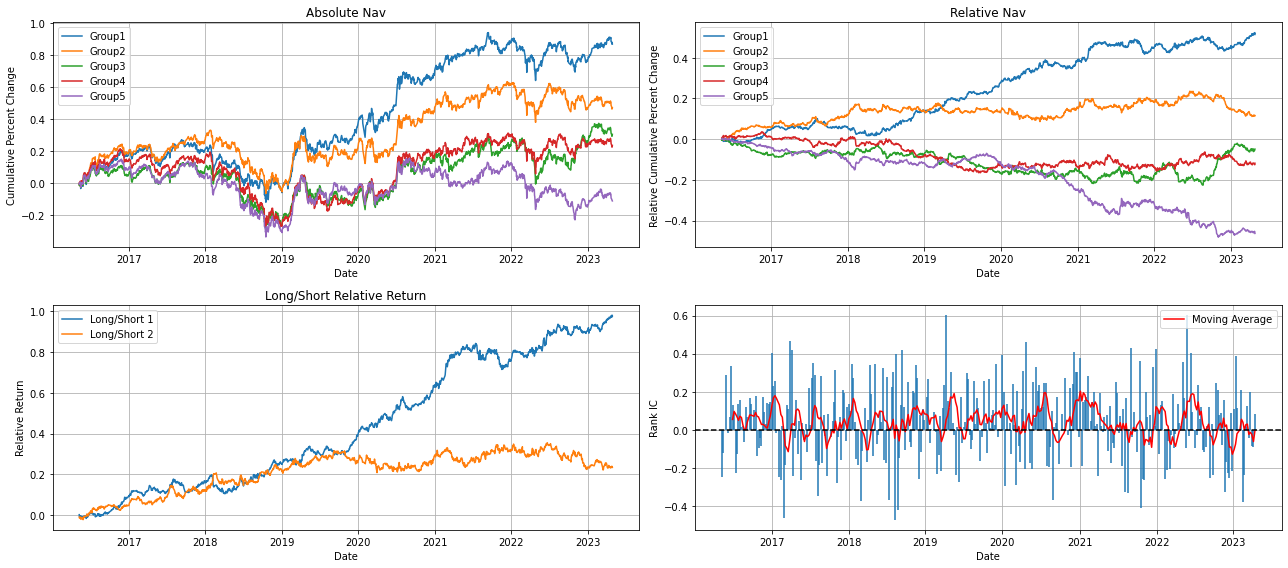

,Freq,Long_Excess_Return,Long_Sharpe_Ratio,Long_Calmar,Long_return,Long_Short_Sharpe,Long_Short_Calmar,Long_TC,Long_Short_TC,rankIC,Long_Win_Rate,Short_Win_Rate,Long_Turnover,Short_Turnover
0,5,7.74%,1.8,0.92,14.56%,2.52,1.72,2.51%,3.78%,4.1%,52.54%,53.96%,51.93%,55.05%


In [20]:
back_test_v2(factor_df, sec_name_df, trd_dt, start_dt, end_dt)

## Multi-Frequency Testing

In [21]:
def multi_freq(factor_df, sec_name_df, trd_dt, start_dt, end_dt, freq_list,assign = False, 
               rate = 0.002, rolling = False, num_grps_int = 5,
              delay_int = 1,roll_window_int = 3):
    
    analyze_table = []
    
    if not rolling and assign:
        raise ValueError('No multi-frequency test for assigned dates')
        return
    
    elif not rolling and not assign:
        for freq in freq_list:
            analyze_df = back_test_v2(factor_df, sec_name_df, trd_dt, start_dt, end_dt, assign,
                                      rate, freq, num_grps_int,delay_int, show_plots = False)
            analyze_table.append(analyze_df)
        table = pd.concat(analyze_table, ignore_index=True)
    
    elif rolling and not assign:
        start_dates = []
        for freq in freq_list:
            start,end = roll_rebalance_dates(TrdDates(factor_df), start_dt, end_dt, freq, 
                                             roll_window_int = round(freq*0.6+1))
            start_dates.extend(start.index.values)
            for start_item, end_item in zip(start,end):
                analyze_df = back_test_v2(factor_df, sec_name_df, trd_dt, start_item, end_item, assign,
                                          rate, freq, num_grps_int, delay_int, show_plots = False)
                analyze_table.append(analyze_df)
    
        table = pd.concat(analyze_table, ignore_index=True)
        table.insert(0, 'Start Date', start_dates)
        
    elif rolling and assign:
        df = roll_rebalance_dates(TrdDt, start_dt, end_dt, freq_str,assign, roll_window_int)
        for i in range(len(df.columns)):
            analyze_df = back_test_v2(factor_df, sec_name_df, trd_dt, start_dt, end_dt, list(df.iloc[:,i]),
                                          rate,num_grps_int=num_grps_int, 
                                      delay_int = delay_int, show_plots = False)
            analyze_table.append(analyze_df)
        table = pd.concat(analyze_table, ignore_index=True)
        start_dates = list(df.columns.values)
        table.insert(0, 'Start Date', start_dates)
        
    return table

## Rolling-Readjustment Dates for Sensitivity Testing

In [22]:
multi_freq(factor_df, sec_name_df, trd_dt, start_dt, end_dt,freq_list, rolling = True)

,Start Date,Freq,Long_Excess_Return,Long_Sharpe_Ratio,Long_Calmar,Long_return,Long_Short_Sharpe,Long_Short_Calmar,Long_TC,Long_Short_TC,rankIC,Long_Win_Rate,Short_Win_Rate,Long_Turnover,Short_Turnover
0,4-Day Priv,5,8.3%,2.34,0.92,13.24%,2.51,1.46,3.07%,2.42%,3.93%,53.65%,54.24%,51.88%,55.44%
1,3-Day Priv,5,8.05%,1.89,1.19,12.43%,2.07,1.83,2.65%,1.54%,4.23%,53.18%,54.66%,53.57%,54.38%
2,2-Day Priv,5,4.31%,1.34,0.46,7.35%,1.56,0.78,-0.88%,-3.14%,3.85%,51.63%,53.47%,51.5%,52.56%
3,1-Day Priv,5,5.9%,1.12,0.79,10.4%,1.78,1.39,0.82%,-0.15%,3.83%,52.11%,53.47%,50.47%,54.15%
4,Origin,5,7.74%,1.80,0.92,14.52%,2.51,1.72,2.5%,3.73%,4.08%,52.58%,53.89%,52.03%,55.02%
5,1-Day After,5,8.47%,2.38,0.94,13.39%,2.53,1.48,3.24%,2.58%,3.97%,53.65%,54.07%,51.88%,55.34%
6,2-Day After,5,7.78%,1.85,1.15,12.11%,2.03,1.78,2.38%,1.21%,4.28%,53.12%,54.6%,53.57%,54.58%
7,3-Day After,5,4.22%,1.33,0.45,7.31%,1.55,0.77,-0.96%,-3.18%,3.9%,51.63%,53.53%,51.4%,52.65%
8,4-Day After,5,5.91%,1.13,0.79,10.27%,1.77,1.37,0.82%,-0.27%,3.88%,52.11%,53.41%,50.47%,54.1%
9,7-Day Priv,10,5.08%,1.24,0.58,7.49%,1.42,0.85,1.4%,0.31%,5.4%,51.37%,53.15%,73.01%,69.5%


# Part III. Back-Testing Factors

# Industry Effective Price-Volume Factors<br>
<br>
1. Momentum

## 1.1 Simple Momentum & 1.2 Second-order Momentum<br>
<br>
Taking different window: 5-day, 10-day, 15-day, 20-day, 40-day, 60-day, 120-day, 180-day, 250-day<br>
<br>

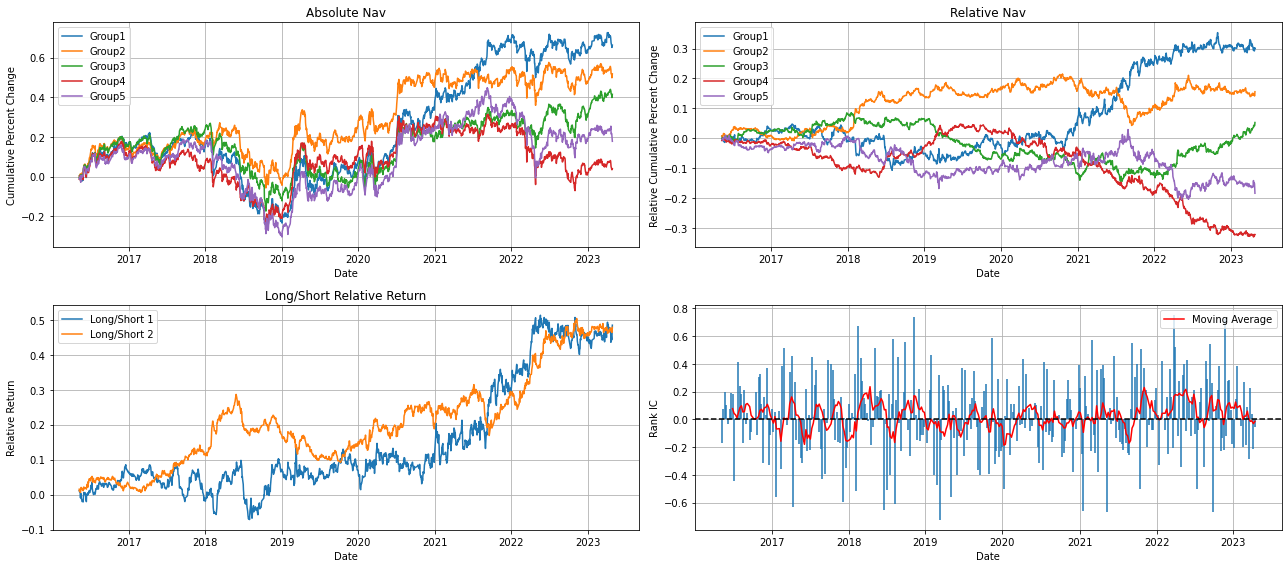

,Freq,Long_Excess_Return,Long_Sharpe_Ratio,Long_Calmar,Long_return,Long_Short_Sharpe,Long_Short_Calmar,Long_TC,Long_Short_TC,rankIC,Long_Win_Rate,Short_Win_Rate,Long_Turnover,Short_Turnover
0,5,4.38%,0.11,0.28,6.5%,0.58,0.42,-6.66%,-15.42%,2.33%,50.53%,51.36%,109.5%,107.91%


In [23]:
second_momentum = pd.read_csv('Data/second_momentum_factor.csv')
back_test_v2(second_momentum, sec_name_df, trd_dt, start_dt, end_dt) 

In [24]:
multi_freq(second_momentum, sec_name_df, trd_dt, start_dt, end_dt,freq_list, rolling = True)

,Start Date,Freq,Long_Excess_Return,Long_Sharpe_Ratio,Long_Calmar,Long_return,Long_Short_Sharpe,Long_Short_Calmar,Long_TC,Long_Short_TC,rankIC,Long_Win_Rate,Short_Win_Rate,Long_Turnover,Short_Turnover
0,4-Day Priv,5,6.59%,0.42,0.74,10.97%,0.76,1.24,-4.53%,-10.98%,1.9%,51.81%,51.45%,110.32%,107.44%
1,3-Day Priv,5,6.61%,0.85,0.54,11.36%,0.85,0.94,-4.47%,-10.68%,1.43%,51.34%,51.69%,109.92%,108.73%
2,2-Day Priv,5,2.16%,-0.09,0.16,6.21%,0.32,0.47,-9.07%,-15.98%,2.57%,49.26%,50.27%,111.41%,108.73%
3,1-Day Priv,5,6.4%,0.35,0.56,12.56%,0.95,1.11,-4.49%,-9.19%,1.47%,50.45%,51.99%,108.04%,107.74%
4,Origin,5,4.63%,0.14,0.30,7.05%,0.62,0.46,-6.4%,-14.85%,2.36%,50.56%,51.45%,109.42%,107.84%
5,1-Day After,5,5.9%,0.34,0.67,10.09%,0.67,1.14,-5.21%,-11.82%,1.7%,51.69%,51.34%,110.22%,107.14%
6,2-Day After,5,6.24%,0.80,0.51,10.86%,0.79,0.90,-4.84%,-11.16%,1.25%,51.22%,51.69%,109.92%,108.53%
7,3-Day After,5,1.63%,-0.15,0.12,5.3%,0.23,0.40,-9.62%,-16.93%,2.35%,49.14%,50.21%,111.61%,108.93%
8,4-Day After,5,6.36%,0.35,0.56,12.45%,0.94,1.10,-4.55%,-9.33%,1.32%,50.5%,51.99%,108.23%,107.84%
9,7-Day Priv,10,2.7%,-0.01,0.21,7.6%,0.29,0.60,-4.89%,-7.54%,3.98%,50.12%,50.54%,150.5%,149.9%


## 1.3 Momentum Spread

In [25]:
# mmt_diff_factor = pd.read_csv('momentum_diff_factor.csv')
# back_test_v2(mmt_diff_factor, sec_name_df, trd_dt, start_dt, end_dt) 

In [26]:
# multi_freq(mmt_diff_factor, sec_name_df, trd_dt, start_dt, end_dt,freq_list, rolling = True)

# 2. Trading Volatility Factors
## 2.1 Transaction Amount Vol

In [27]:
# roll_ValTrd_factor = pd.read_csv('rolling_ValTrd_factor.csv')
# back_test_v2(roll_ValTrd_factor, sec_name_df, trd_dt, start_dt, end_dt) 

In [28]:
# multi_freq(roll_ValTrd_factor, sec_name_df, trd_dt, start_dt, end_dt,freq_list, rolling = True)

## 2.2 Transaction Volume Vol

In [29]:
# roll_ShrTrd_factor = pd.read_csv('rolling_ShrTrd_factor.csv')
# back_test_v2(roll_ShrTrd_factor, sec_name_df, trd_dt, start_dt, end_dt) 

In [30]:
# multi_freq(roll_ShrTrd_factor, sec_name_df, trd_dt, start_dt, end_dt,freq_list, rolling = True)

# 3. Turnover Factors

## 3.1 Turnover Rate

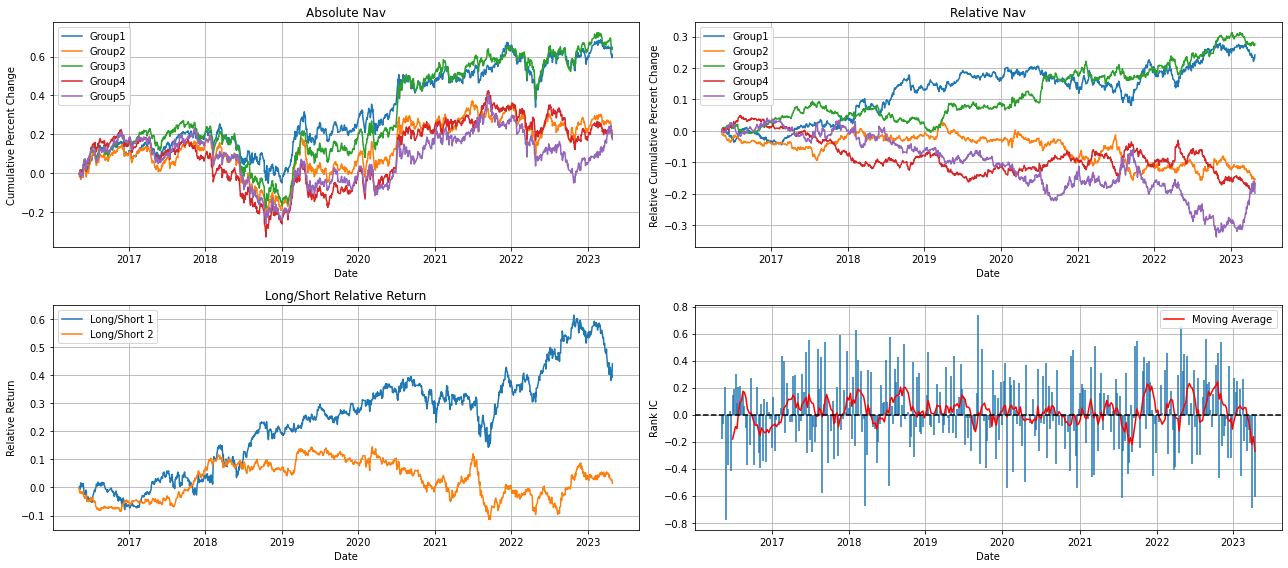

,Freq,Long_Excess_Return,Long_Sharpe_Ratio,Long_Calmar,Long_return,Long_Short_Sharpe,Long_Short_Calmar,Long_TC,Long_Short_TC,rankIC,Long_Win_Rate,Short_Win_Rate,Long_Turnover,Short_Turnover
0,5,3.29%,0.35,0.26,5.68%,0.76,0.46,-2.52%,-5.65%,1.96%,50.95%,50.59%,57.67%,54.7%


In [31]:
ex_rate_factor = pd.read_csv('Data/ex_rate_factor.csv')
back_test_v2(ex_rate_factor, sec_name_df, trd_dt, start_dt, end_dt) 

In [32]:
multi_freq(ex_rate_factor, sec_name_df, trd_dt, start_dt, end_dt,freq_list, rolling = True)

,Start Date,Freq,Long_Excess_Return,Long_Sharpe_Ratio,Long_Calmar,Long_return,Long_Short_Sharpe,Long_Short_Calmar,Long_TC,Long_Short_TC,rankIC,Long_Win_Rate,Short_Win_Rate,Long_Turnover,Short_Turnover
0,4-Day Priv,5,3.6%,0.48,0.27,6.1%,0.73,0.46,-2.19%,-5.23%,1.52%,50.62%,50.15%,57.44%,54.96%
1,3-Day Priv,5,1.61%,-0.08,0.08,6.09%,0.77,0.32,-4.01%,-5.19%,2.38%,49.32%,50.92%,55.75%,56.15%
2,2-Day Priv,5,2.53%,0.01,0.12,6.32%,0.88,0.29,-3.09%,-4.86%,1.64%,48.25%,51.34%,55.75%,55.16%
3,1-Day Priv,5,3.86%,0.48,0.32,6.74%,1.08,0.56,-1.73%,-4.45%,2.45%,49.38%,51.16%,55.46%,55.56%
4,Origin,5,3.59%,0.41,0.29,6.34%,0.80,0.51,-2.22%,-5.0%,2.14%,51.1%,50.62%,57.64%,54.86%
5,1-Day After,5,3.24%,0.43,0.25,5.81%,0.70,0.44,-2.55%,-5.51%,1.4%,50.5%,50.27%,57.44%,54.86%
6,2-Day After,5,1.15%,-0.16,0.06,5.71%,0.74,0.30,-4.47%,-5.55%,2.28%,49.14%,51.04%,55.75%,55.95%
7,3-Day After,5,2.17%,-0.06,0.10,6.1%,0.86,0.28,-3.44%,-5.05%,1.56%,48.07%,51.45%,55.65%,54.96%
8,4-Day After,5,3.73%,0.46,0.31,7.01%,1.11,0.58,-1.86%,-4.16%,2.55%,49.2%,51.22%,55.46%,55.36%
9,7-Day Priv,10,5.16%,0.33,0.51,9.16%,0.64,0.90,0.67%,0.23%,3.12%,48.57%,50.06%,89.22%,87.82%


# 4. Long-Short Factors

## 4.1 Total Long-Short

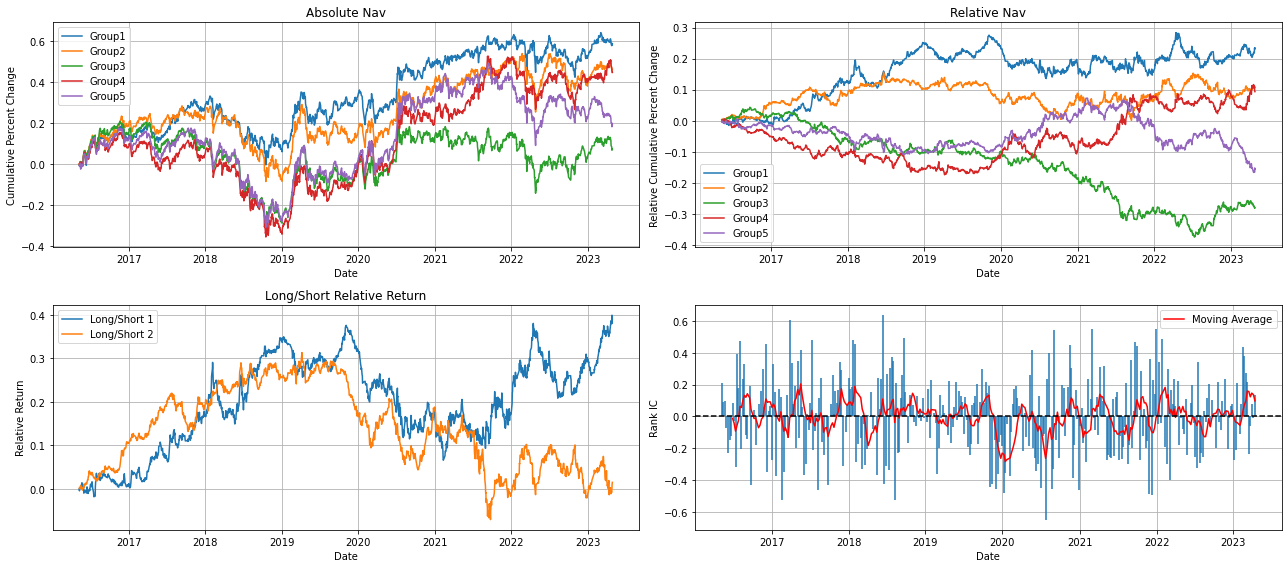

,Freq,Long_Excess_Return,Long_Sharpe_Ratio,Long_Calmar,Long_return,Long_Short_Sharpe,Long_Short_Calmar,Long_TC,Long_Short_TC,rankIC,Long_Win_Rate,Short_Win_Rate,Long_Turnover,Short_Turnover
0,5,3.21%,-0.1,0.23,5.67%,0.44,0.41,0.14%,-0.01%,0.2%,48.7%,51.07%,30.46%,25.91%


In [33]:
ls_diff_factor = pd.read_csv('Data/ls_diff_factor.csv')
back_test_v2(ls_diff_factor, sec_name_df, trd_dt, start_dt, end_dt) 

In [34]:
multi_freq(ls_diff_factor, sec_name_df, trd_dt, start_dt, end_dt,freq_list, rolling = True)

,Start Date,Freq,Long_Excess_Return,Long_Sharpe_Ratio,Long_Calmar,Long_return,Long_Short_Sharpe,Long_Short_Calmar,Long_TC,Long_Short_TC,rankIC,Long_Win_Rate,Short_Win_Rate,Long_Turnover,Short_Turnover
0,4-Day Priv,5,4.01%,-0.35,0.28,4.86%,-0.11,0.34,0.67%,-1.15%,1.21%,49.32%,50.45%,33.13%,26.49%
1,3-Day Priv,5,3.97%,-0.07,0.28,5.54%,0.19,0.39,0.73%,-0.26%,0.06%,49.5%,50.09%,32.14%,25.4%
2,2-Day Priv,5,3.38%,0.06,0.20,4.46%,0.23,0.26,0.29%,-1.13%,-0.13%,49.32%,49.67%,30.65%,24.8%
3,1-Day Priv,5,3.67%,0.23,0.28,5.11%,0.40,0.39,0.55%,-0.55%,-0.29%,49.02%,50.21%,30.95%,25.2%
4,Origin,5,3.14%,-0.11,0.22,5.41%,0.40,0.39,0.06%,-0.28%,0.16%,48.66%,50.98%,30.56%,25.89%
5,1-Day After,5,3.97%,-0.36,0.28,4.82%,-0.12,0.34,0.67%,-1.11%,1.22%,49.26%,50.33%,32.74%,26.09%
6,2-Day After,5,4.05%,-0.05,0.28,6.18%,0.28,0.43,0.86%,0.47%,0.17%,49.5%,50.21%,31.65%,25.0%
7,3-Day After,5,3.58%,0.10,0.21,5.03%,0.29,0.29,0.54%,-0.46%,-0.01%,49.44%,49.73%,30.16%,24.31%
8,4-Day After,5,3.96%,0.28,0.30,5.48%,0.46,0.42,0.88%,-0.08%,-0.21%,49.2%,50.27%,30.56%,24.6%
9,7-Day Priv,10,2.89%,0.26,0.19,3.49%,0.23,0.23,0.38%,-1.1%,0.67%,48.93%,50.0%,49.9%,41.12%


## 4.2 Long-Short Difference

In [35]:
# ls_diff_chg_factor = pd.read_csv('ls_diff_chg_factor.csv')
# back_test_v2(ls_diff_chg_factor, sec_name_df, trd_dt, start_dt, end_dt) 

In [36]:
# multi_freq(ls_diff_chg_factor, sec_name_df, trd_dt, start_dt, end_dt,freq_list, rolling = True)

# 5. Volume-Price Factors

## 5.1 Volume-Price Covariance

In [37]:
# cov_matrix_factor = pd.read_csv('cov_matrix_factor.csv')
# back_test_v2(cov_matrix_factor, sec_name_df, trd_dt, start_dt, end_dt) 

In [38]:
# multi_freq(cov_matrix_factor, sec_name_df, trd_dt, start_dt, end_dt,freq_list, rolling = True)

## 5.2 Correlation

In [39]:
# corr_factor = pd.read_csv('corr_factor.csv')
# back_test_v2(corr_factor, sec_name_df, trd_dt, start_dt, end_dt) 

In [40]:
# multi_freq(corr_factor, sec_name_df, trd_dt, start_dt, end_dt,freq_list, rolling = True)

## 5.3 First-Order Correlation

In [41]:
# rank_corr_factor = pd.read_csv('rank_corr_factor.csv')
# back_test_v2(rank_corr_factor, sec_name_df, trd_dt, start_dt, end_dt) 

In [42]:
# multi_freq(rank_corr_factor, sec_name_df, trd_dt, start_dt, end_dt,freq_list, rolling = True)

# 6. Co-Directionality Factors

In [43]:
# rank_corr_price_factor = pd.read_csv('rank_corr_price_factor.csv')
# back_test_v2(rank_corr_price_factor, sec_name_df, trd_dt, start_dt, end_dt) 

In [44]:
# multi_freq(rank_corr_price_factor, sec_name_df, trd_dt, start_dt, end_dt,freq_list, rolling = True)